# simple analyses for Figure 1

In [1]:
import sys
sys.path.insert(0, '../../flygenvectors/')
import os
import numpy as np
from glob import glob
import copy
from importlib import reload
import pickle

import scipy.io as sio
from scipy import sparse, signal
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from skimage.restoration import denoise_tv_chambolle

import data as dataUtils
import regression_model as model
import plotting
import flygenvectors.ssmutils as utils
import flygenvectors.utils as futils


### load data (raw and deconvolved) and reg model

In [2]:
# load deconvolved data and point to the right entry
# main_fig_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/figs/'
# main_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/dataShare/_main/'
dirs = futils.get_dirs()
remake_data_pickles = False

exp_list = [
            ['2018_08_24','fly3_run1'],
            ['2018_08_24','fly2_run2'],
            ['2019_07_01','fly2'],
            ['2019_10_14','fly3'],
            ['2019_06_28','fly2'],
            ['2019_10_14','fly2'],
            ['2019_10_21','fly1'],
            ['2019_10_10','fly3'],
            ['2019_08_14','fly1']]

# Excluded datasets:
# ['2019_06_30','fly1'], ['2019_10_14','fly4'], ['2019_10_02','fly2'], ['2019_10_18','fly3'],

# dataset_idx = []
# model_fit = []
# exp_list_fit = []
data_tot = []
n_flies = len(exp_list)
for i in range(len(exp_list)):
    exp_date = exp_list[i][0]
    fly_num = exp_list[i][1]
    expt_id = exp_list[i][0] + '_' + exp_list[i][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    if remake_data_pickles:
        data_dict = dataUtils.load_timeseries_simple(exp_date,fly_num,dirs['data'])
        # pdb.set_trace()
        ro = model.reg_obj(exp_id=expt_id, 
                           data_dict=data_dict,
                           fig_dirs=fig_dirs,
                           split_behav=False)
        data_dict = ro.preprocess()
        pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )
    else:
        data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    data_tot.append({})
    data_tot[i]['data_dict'] = data_dict

In [47]:
# nf=0
# c = data_tot[nf]['data_dict']['aligned_centroids'][:,2]
# plotting.show_colorCoded_cellMap_points(data_tot[nf]['data_dict'], c, c, cmap=plotting.cold_to_hot_cmap(), pval=0.01, sort_by='val', color_lims_scale=[0,1])
# # plt.savefig(fig_dirs['regfig_folder']+expt_id+'_cells_predicting_run_starts_map.pdf',transparent=False, bbox_inches='tight')


# Behavior XCorr

In [211]:
lags_tot = []
c_tot = []
for nf in range(len(data_tot)):
    data_dict = data_tot[nf]['data_dict']

    mxlags=int(300*data_dict['scanRate'])
    t = np.linspace(0,300,300)
    # fit_long = .58*.7*np.exp(-t/5) + .58*.3*np.exp(-t/60) + .42*np.exp(-t/700)
    fit_long = .56*.7*np.exp(-t/5) + .56*.3*np.exp(-t/60) + .44*np.exp(-t/550)

    # plt.figure(figsize=(.1,.1))
    # lags, c, _, _ = plt.xcorr(data_dict['behavior'], data_dict['behavior'], usevlines=False, maxlags=mxlags, marker='.')
    # plt.gca().axis('off')

    beh = data_dict['behavior'] - data_dict['behavior'].mean()
    c = np.correlate(beh, beh, "same")/(len(beh)*beh.var())
    if len(c)%2 == 0:
        lags = np.linspace( -np.floor(len(c)/2)+1, np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    else:
        lags = np.linspace( -np.floor(len(c)/2), np.floor(len(c)/2), len(c) )/data_dict['scanRate']
    
    c_tot.append(c)
    lags_tot.append(lags)

In [227]:
# bin autocorrelations from all flies to be on same points
bins = np.linspace(-300,301,602)
c_binned = np.zeros((len(c_tot),len(bins)))
for nf in range(len(c_tot)):
    l = lags_tot[nf]
    for i in range(len(bins)-1):
        c_binned[nf,i] = c_tot[nf][ (bins[i]<l)*(l<bins[i+1]) ].mean()
    c_binned[nf,301] = 1
    
c_mean = c_binned.mean(axis=0)
c_std = c_binned.std(axis=0)/np.sqrt(c_binned.shape[0])

/Users/evan/anaconda3/envs/flygenvectors/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


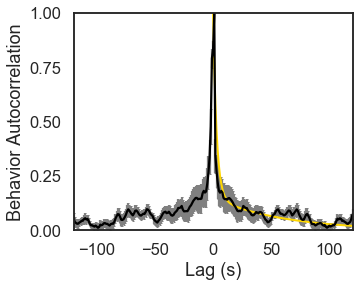

In [239]:
plt.figure(figsize=(5,4))
ax1 = plt.axes()
ax1.errorbar(bins, c_mean, yerr=c_std,color='k',ecolor='gray',capsize=1)
ax1.set_xlim(-120,120)
ax1.set_ylim(0,1)
ax1.set_yticks([0,.25,.5,.75,1])
# xticklabels = np.array([-300,-150,0,150,300])
# xticklocs = xticklabels #*data_dict['scanRate']
# plt.xticks(ticks=xticklocs, labels=xticklabels)
ax1.set_xlabel('Lag (s)')
ax1.set_ylabel('Behavior Autocorrelation')

fit_long = .85*np.exp(-t/3) + .15*np.exp(-t/60)
ax1.plot(t,fit_long, linewidth=2, color='gold' )
plt.savefig(dirs['results']+'_summary/regression/behav_autocorr.pdf',transparent=True, bbox_inches='tight')
plt.show()

# XCorr between dF/F and behavior

In [160]:
nf=2
data_dict = data_tot[nf]['data_dict']

In [161]:
mxlags = 60
N = data_dict['dFF_unnormalized'].shape[0]
c_max = np.zeros((N,2))
b = data_dict['behavior']-data_dict['behavior'].mean()
x = np.linspace(-.5*len(b)/data_dict['scanRate'],.5*len(b)/data_dict['scanRate'],len(b))
valid = (-mxlags<x)*(x<mxlags)
for n in range(N):
    f = data_dict['dFF_unnormalized'][n,:].copy()
    c = np.correlate(f-f.mean(), b, "same")/(f.std()*b.std()*len(f))
    c_max[n,:] = [x[valid][np.argmax(c[valid])], c[valid].max()]

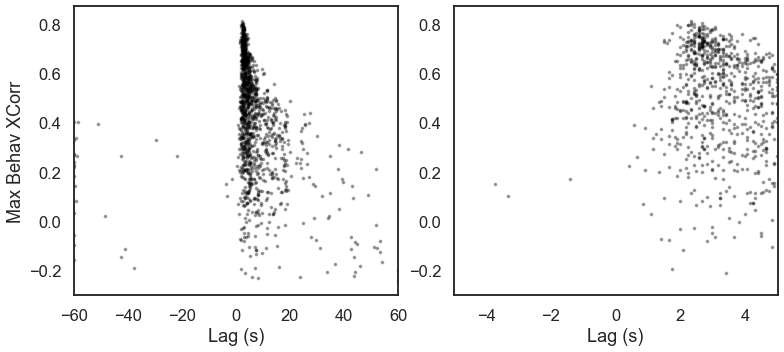

In [163]:
plt.figure(figsize=(11,5))
plt.subplot(121)
plt.scatter(c_max[:,0],c_max[:,1],s=5, color='k', alpha=0.3)
# plt.scatter(c_max[408,0],c_max[408,1],s=5, color='r')
plt.xlabel('Lag (s)')
plt.ylabel('Max Behav XCorr')
plt.xlim(-60,60)
plt.subplot(122)
plt.scatter(c_max[:,0],c_max[:,1],s=5, color='k', alpha=0.3)
plt.xlabel('Lag (s)')
plt.xlim(-5,5)
plt.tight_layout()
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
# plt.savefig(dirs['results']+'_summary/regression/cell_xcorr_'+expt_id+'.pdf',transparent=True, bbox_inches='tight')
plt.show()

# Power spectrum of dF/F

In [122]:
grid_points = 128
mx_tmp = np.zeros((len(data_tot),3))
for nf in range(len(exp_list)):
    mx_tmp[nf,:] = data_tot[nf]['data_dict']['aligned_centroids'].max(axis=0)
mx = mx_tmp.max(axis=0)

grid_image_2d_tot = []
grid_image_ctrl_2d_tot = []
powerx_2d_tot = []
powerx_ctrl_2d_tot = []
for nf in range(len(exp_list)):
    data_dict = data_tot[nf]['data_dict']
    dFF_mean = data_dict['dFF'].mean(axis=0)
    N = data_tot[nf]['data_dict']['aligned_centroids'].shape[0]
    
    grid_image_2d = np.zeros((grid_points,data_dict['dFF'].shape[1]))
    grid_image_ctrl_2d = np.zeros((grid_points,data_dict['dFF'].shape[1]))
    for n in range(N):
        if(np.mod(n,200)==0): print(n,end=' ')
        x,y,z = np.round(grid_points*(data_dict['aligned_centroids'][n,:]/mx)).astype(int)-1
        grid_image_2d[y,:] += data_dict['dFF'][n,:] 
        grid_image_ctrl_2d[y,:] += dFF_mean  
    
    grid_image_2d_tot.append(grid_image_2d)
    grid_image_ctrl_2d_tot.append(grid_image_ctrl_2d)
    
    out_2d = np.fft.rfft2(grid_image_2d)
    out_ctrl_2d = np.fft.rfft2(grid_image_ctrl_2d)
    power_2d = np.abs(out_2d)**2
    power_ctrl_2d = np.abs(out_ctrl_2d)**2

    powerx_2d = np.fft.fftshift( power_2d.max(axis=1) )
    powerx_ctrl_2d = np.fft.fftshift( power_ctrl_2d.max(axis=1) )
    powerx_2d_tot.append(powerx_2d)
    powerx_ctrl_2d_tot.append(powerx_ctrl_2d)

0 200 400 600 800 1000 1200 1400 1600 1800 2000 0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 0 200 400 600 800 1000 1200 0 200 400 600 800 1000 1200 1400 1600 0 200 400 600 800 1000 1200 0 200 400 600 0 200 400 600 800 1000 0 200 400 600 800 1000 1200 1400 1600 0 200 400 600 800 1000 1200 1400 

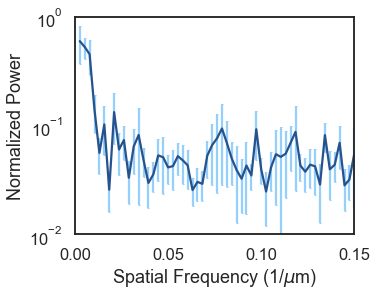

In [152]:
import matplotlib.ticker as ticker

freqs = np.fft.fftshift( np.fft.fftfreq(powerx_2d.shape[0]) )
fscale = grid_points/data_dict['dims_in_um'][1]

plt.figure(figsize=(5,4))
ax1 = plt.axes()
# ax1.plot(freqs, powerx_shapectrl,'--' )
# ax1.plot(freqs, powerx_ctrl )
exp_for_plot = [i for i in range(len(exp_list))] #
plot_power = np.zeros((len(exp_for_plot), powerx_2d_tot[0][freqs>0].shape[0]))
for nf in enumerate(exp_for_plot):
    plot_power[nf[0]] = (powerx_2d_tot[nf[1]]-powerx_ctrl_2d_tot[nf[1]])[freqs>0]
    plot_power[nf[0]] /= plot_power[nf[0]].max()

power_mean = plot_power.mean(axis=0)
power_std = plot_power.std(axis=0)/np.sqrt(plot_power.shape[0])
#plot_power = (powerx_2d_tot[nf]-powerx_ctrl_2d_tot[nf])[freqs>0]
ax1.errorbar(freqs[freqs>0]*fscale, power_mean, yerr=power_std,color='#26538d',ecolor='#95d0fc',capsize=1)
# ax1.plot(freqs[freqs>0]*fscale, power_mean)
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_xlabel(r'Spatial Frequency (1/$\mu$m)')
ax1.set_ylabel('Normalized Power')
ax1.set_ylim(1e-2,1e0)
ax1.set_xlim(0,0.15) #freqs.max()*fscale)
# ax1.set_xlim(2e-3,1e-1) #freqs.max()*fscale)
# ax1.set_xticks([.003,.01,.03,.1])

# ax1.xaxis.grid(True, which='minor')
# ax1.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=4))
# ax1.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, numticks=10))

# expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
# fig_dirs = futils.get_fig_dirs(expt_id)
plt.savefig(dirs['results']+'_summary/lateral_power_spectrum.pdf',transparent=True, bbox_inches='tight')
    
plt.show()
# STOPPED HERE.  JUST FIX HORIZONTAL AXIS TO BE IN MEANINGFUL FREQUENCY (1/UM INSTEAD OF 1/PX?)
# is lower bound here because of "max" operation? (test in simple sinusoidal case)

## FFT SANDBOX

In [6]:
grid_image = np.zeros((grid_points,grid_points,grid_points,data_dict['dFF'].shape[1]))
grid_image_ctrl = np.zeros((grid_points,grid_points,grid_points,data_dict['dFF'].shape[1]))
grid_image_shapectrl = np.zeros((grid_points,grid_points,grid_points,1))
dFF_mean = data_dict['dFF'].mean(axis=0)
grid_image_shapectrl = grid_image_shapectrl@np.expand_dims(dFF_mean,axis=0)
for n in range(N):
    if(np.mod(n,200)==0): print(n,end=' ')
    x,y,z = np.round(grid_points*(data_dict['aligned_centroids'][n,:]/mx)).astype(int)-1
    grid_image[x,y,z,:] += data_dict['dFF'][n,:] 
    grid_image_ctrl[x,y,z,:] += dFF_mean  


0 200 400 600 800 1000 1200 1400 1600 1800 2000 

In [8]:
out = np.fft.rfftn(grid_image)
out_ctrl = np.fft.rfftn(grid_image_ctrl)
out_shapectrl = np.fft.rfftn(grid_image_shapectrl)

In [10]:
power = np.abs(out)**2
power_ctrl = np.abs(out_ctrl)**2
power_shapectrl = np.abs(out_shapectrl)**2

In [30]:
powerx = np.fft.fftshift( power.max(axis=3).max(axis=2).max(axis=0) )
powerx_ctrl = np.fft.fftshift( power_ctrl.max(axis=3).max(axis=2).max(axis=0) )
powerx_shapectrl = np.fft.fftshift( power_shapectrl.max(axis=3).max(axis=2).max(axis=0) )

In [21]:
powert = np.fft.fftshift( power.max(axis=2).max(axis=1).max(axis=0) )
powert_ctrl = np.fft.fftshift( power_ctrl.max(axis=2).max(axis=1).max(axis=0) )
powert_shapectrl = np.fft.fftshift( power_shapectrl.max(axis=2).max(axis=1).max(axis=0) )

In [31]:
freqs = np.fft.fftshift( np.fft.fftfreq(powerx.shape[0]) )

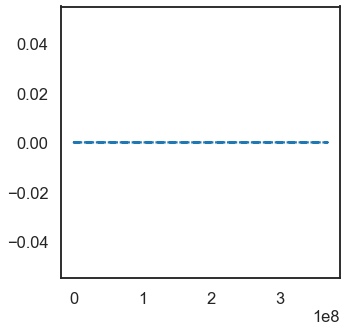

In [24]:
freqst = np.fft.fftshift( np.fft.fftfreq(powert.shape[0]) )
plt.figure(figsize=(5,5))
ax1 = plt.axes()
ax1.plot(powert, powert_shapectrl,'--' )
# ax1.plot(freqst, powert_ctrl )
# ax1.plot(freqst, powert)

In [44]:
nf

0

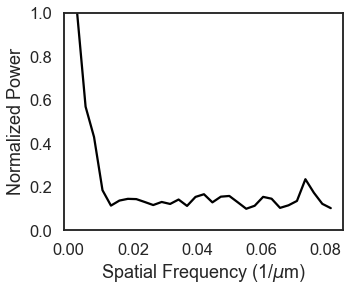

In [46]:
N = 64
M = data_dict['dims_in_um'][1]

plt.figure(figsize=(5,4))
ax1 = plt.axes()
# ax1.plot(freqs, powerx_shapectrl,'--' )
# ax1.plot(freqs, powerx_ctrl )
plot_power = (powerx-powerx_ctrl)[freqs>0]
ax1.plot(freqs[freqs>0]*N/M, plot_power/plot_power.max(),'k' )
# ax1.set_yscale('log')
ax1.set_xlabel(r'Spatial Frequency (1/$\mu$m)')
ax1.set_ylabel('Normalized Power')
ax1.set_ylim(0,1)

expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
fig_dirs = futils.get_fig_dirs(expt_id)
plt.savefig(fig_dirs['regfig_folder']+expt_id +'_'+'lateral_power_spectrum.pdf',transparent=True, bbox_inches='tight')
    
plt.show()
# STOPPED HERE.  JUST FIX HORIZONTAL AXIS TO BE IN MEANINGFUL FREQUENCY (1/UM INSTEAD OF 1/PX?)
# is lower bound here because of "max" operation? (test in simple sinusoidal case)

In [39]:
1/.01

100.0

(-2, 2)

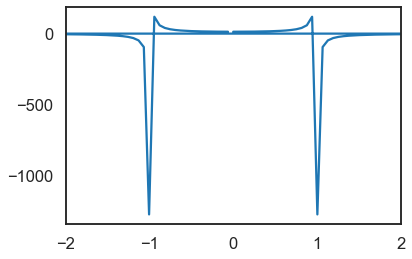

In [17]:
N=10000
M=100
t = np.linspace(0,M,N)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq*N/M*2*np.pi, sp.real)
plt.xlim(-2,2)

In [18]:
sp.real[:4], sp.real[-4:]

(array([13.51343839, 13.56600229, 13.7262236 , 14.0020017 ]),
 array([14.40761075, 14.0020017 , 13.7262236 , 13.56600229]))

In [20]:
(np.abs(sp)**2)[:4], (np.abs(sp)**2)[-4:]

(array([182.61301721, 193.8899584 , 228.7774641 , 290.63970736]),
 array([385.79217447, 290.63970736, 228.7774641 , 193.8899584 ]))

In [41]:
outxy = out.max(axis=3).max(axis=2)
outxz = out.max(axis=3).max(axis=1)
outyz = out.max(axis=3).max(axis=0)

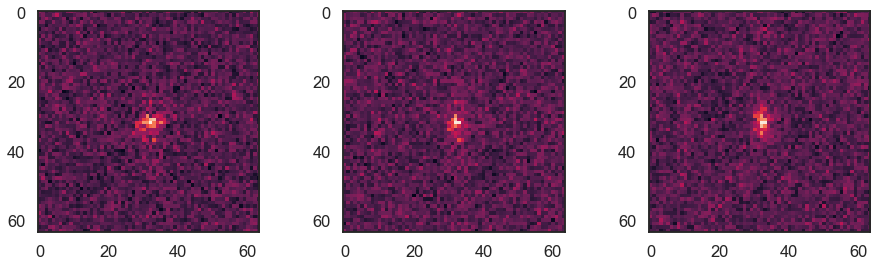

In [43]:
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(np.log(np.abs(np.fft.fftshift(outxy))**2))
plt.subplot(132)
plt.imshow(np.log(np.abs(np.fft.fftshift(outxz))**2))
plt.subplot(133)
plt.imshow(np.log(np.abs(np.fft.fftshift(outyz))**2))
plt.tight_layout()
plt.show()

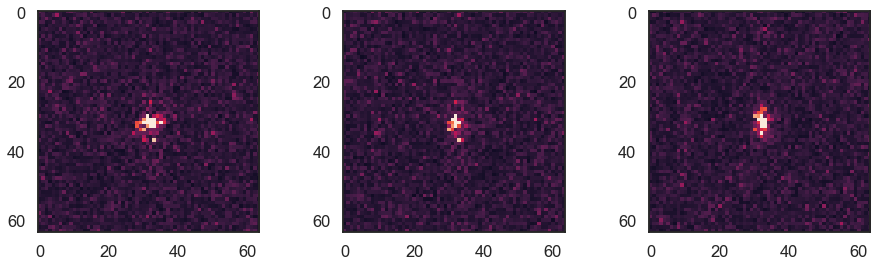

In [49]:
cmin = 1e1
cmax = 2e7
plt.figure(figsize=(13,4))
plt.subplot(131)
plt.imshow(np.abs(np.fft.fftshift(outxy))**2)
plt.clim(cmin, cmax)
plt.subplot(132)
plt.imshow(np.abs(np.fft.fftshift(outxz))**2)
plt.clim(cmin, cmax)
plt.subplot(133)
plt.imshow(np.abs(np.fft.fftshift(outyz))**2)
plt.clim(cmin, cmax)
plt.tight_layout()
plt.show()

In [22]:
out0.shape

(50, 50, 50, 3435)

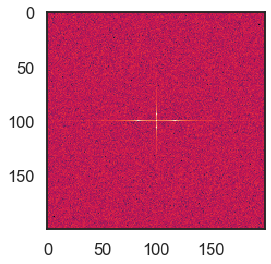

In [11]:
[X, Y] = np.meshgrid(2 * np.pi * np.arange(200) / 12,
                     2 * np.pi * np.arange(200) / 34)
S = np.sin(X) + np.cos(Y) + np.random.uniform(0, 1, X.shape)
FS = np.fft.fftn(S)
plt.imshow(np.log(np.abs(np.fft.fftshift(FS))**2))
plt.show()

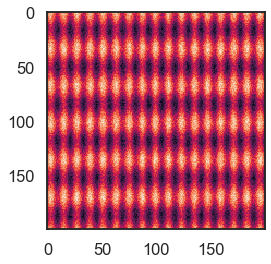

In [12]:
plt.imshow(S)